# 💾 Packages / Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import make_interp_spline

# 📊 Data importation

In [2]:
tickers = ['AAPL', 'NVDA', 'AMD', 'DELL', 'AVGO', 'INTC', 'AMZN', 'MSFT', '9988.HK', 'META', 'GOOG', 'F', 'TSLA']
start = '2019-11-26' #date of 9988.hk
end = '2025-04-10'

In [3]:
df = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False) #auto_adjust=False allows to get (Adj close)

[*********************100%***********************]  13 of 13 completed


In [4]:
df = df['Adj Close']

# 🎭 Data observation

In [5]:
df.head()

Ticker,9988.HK,AAPL,AMD,AMZN,AVGO,DELL,F,GOOG,INTC,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,,,,
2019-11-26,186.966522,63.985779,38.990002,89.847000,27.097610,25.062977,6.991634,65.367882,51.955212,198.036636,145.123489,5.397872,21.927999
2019-11-27,192.547607,64.845253,39.410000,90.925499,27.283529,23.710642,7.061474,65.340012,51.611191,201.052429,145.400345,5.432724,22.086000
2019-11-28,203.311127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-29,197.730042,64.702415,39.150002,90.040001,27.092464,22.848352,7.030433,64.940414,51.205433,200.694138,144.503006,5.395382,21.996000
2019-12-02,194.839844,63.954319,38.730000,89.080002,26.622086,22.485531,6.991634,64.191956,50.861420,198.763229,142.756165,5.208932,22.324667


In [6]:
df.shape

(1386, 13)

In [7]:
df.size

18018

In [8]:
df.isna().sum()

Ticker
9988.HK    66
AAPL       37
AMD        37
AMZN       37
AVGO       37
DELL       37
F          37
GOOG       37
INTC       37
META       37
MSFT       37
NVDA       37
TSLA       37
dtype: int64

In [9]:
while df.isna().any().any():
    df.fillna(df.shift(1), inplace=True) #looping because several following days of NaN

In [10]:
df.isna().any()

Ticker
9988.HK    False
AAPL       False
AMD        False
AMZN       False
AVGO       False
DELL       False
F          False
GOOG       False
INTC       False
META       False
MSFT       False
NVDA       False
TSLA       False
dtype: bool

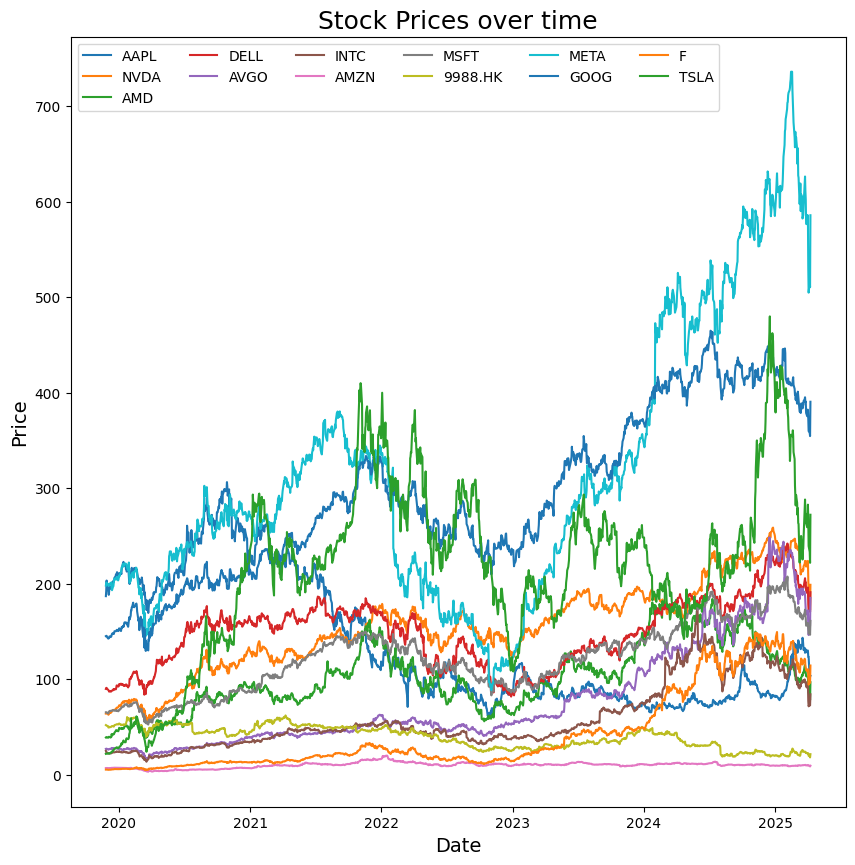

In [11]:
plt.figure(figsize = (10,10))
plt.plot(df, label=tickers)
plt.title('Stock Prices over time', fontsize = 18)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Stock Price', fontsize = 14)
plt.ylabel('Price')
plt.legend(loc='best', ncols=6)
plt.show()

# 💸 Returns time series creation

In [12]:
df_returns = np.log(df/df.shift(1))
df_returns.dropna(inplace=True)

In [13]:
df_returns.head()

Ticker,9988.HK,AAPL,AMD,AMZN,AVGO,DELL,F,GOOG,INTC,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,,,,
2019-11-27,0.029414,0.013343,0.010714,0.011932,0.006838,-0.055468,0.009939,-0.000426,-0.006644,0.015114,0.001906,0.006436,0.007180
2019-11-28,0.054394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-29,-0.027835,-0.002205,-0.006619,-0.009786,-0.007028,-0.037045,-0.004405,-0.006134,-0.007893,-0.001784,-0.006191,-0.006897,-0.004083
2019-12-02,-0.014725,-0.011629,-0.010786,-0.010719,-0.017514,-0.016007,-0.005534,-0.011592,-0.006741,-0.009668,-0.012162,-0.035169,0.014832
2019-12-03,-0.014945,-0.017991,0.004380,-0.006555,-0.013609,-0.006728,-0.013408,0.004147,-0.027963,-0.004416,-0.001606,-0.007628,0.003964


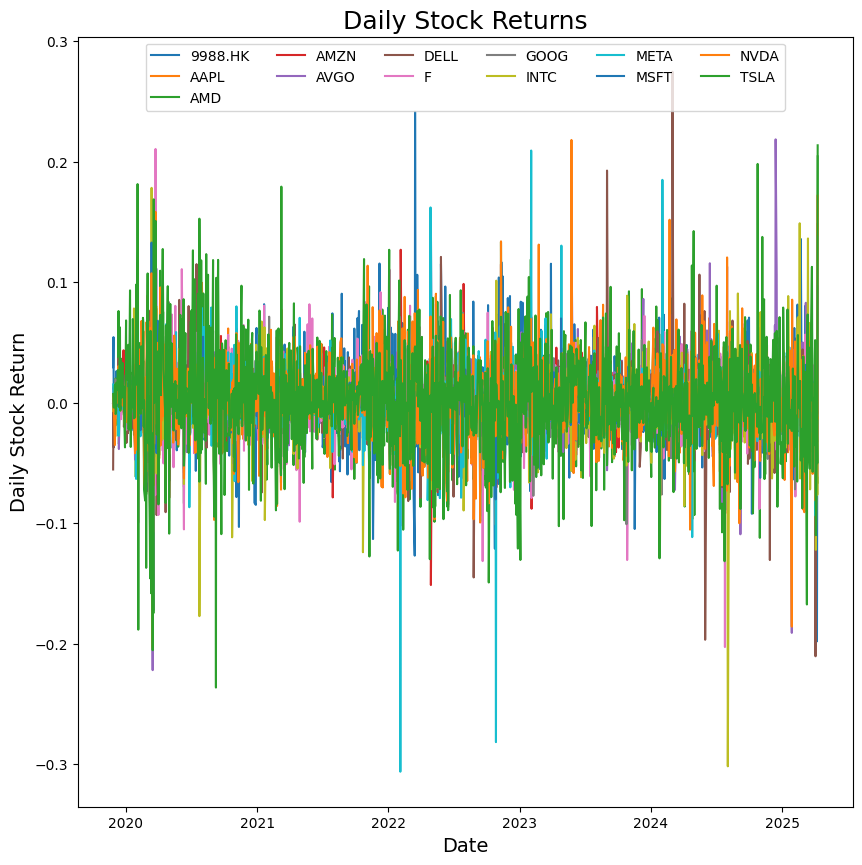

In [14]:
plt.figure(figsize = (10,10))
plt.plot(df_returns, label=df_returns.columns)
plt.title('Daily Stock Returns', fontsize = 18)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Daily Stock Return', fontsize = 14)
plt.legend(loc='upper center', ncol=6)
plt.show()

# 🧮 Formulas and variables for portfolio creation

#### 🪃 E(Pr) = transposed(weights) * mean_returns

In [15]:
def portfolio_return(weights):
    return (weights.T @ df_returns.mean()) * 251 #annualized

#### ☣️ V(Pr) = (transposed(weights) * cov_matrix * weights) **1/2

In [16]:
def portfolio_volatility(weights):
    return np.sqrt(weights.T @ df_returns.cov() @ weights) * np.sqrt(251) #annualized

#### 🏋️ initial_weights : uniform weights

In [17]:
initial_weights = np.array([1/len(tickers)]*len(tickers))

#### 🧑🏻‍🏫 Initial Return and Risk of a simple portfolio

In [18]:
print(f'Portfolio return: {portfolio_return(initial_weights)*100:.3f}%')
print(f'Porfolio risk: {portfolio_volatility(initial_weights)*100:.3f}%')

Portfolio return: 18.562%
Porfolio risk: 29.906%


# 🤠 Efficient Frontier creation

#### 🐁 Trying to create efficient frontier with random portfolios

In [19]:
returns = []
stds = []
weights = []

In [20]:
np.random.seed(123)
for _ in range(500):
    weight = np.random.rand(len(tickers))
    weight /= weight.sum() #normlize weights to sum up to 1
    mu = portfolio_return(weight)
    sd = portfolio_volatility(weight)
    returns.append(mu)
    stds.append(sd)
    weights.append(weight)

In [21]:
data = pd.DataFrame(zip(returns, stds), columns = ['returns', 'stds'])

In [22]:
data = data.sort_values('stds')
data['stds'] = data['stds'].round(3)
efficient_frontier = data.loc[data.groupby('stds')['returns'].idxmax()]

In [44]:
x = efficient_frontier['stds']
y = efficient_frontier['returns']

x_new = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_new)

In [48]:
y_smooth.sort()

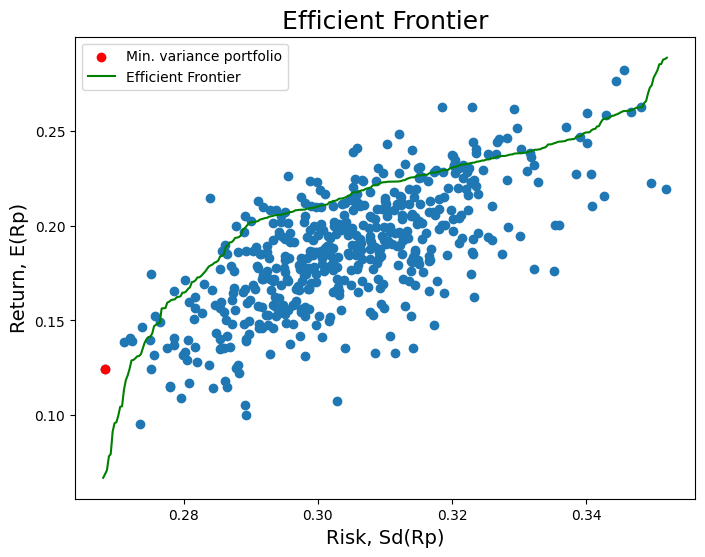

In [49]:
plt.figure(figsize = (8,6))
plt.scatter(stds, returns)
plt.scatter(min(stds), returns[stds.index(min(stds))], color='red', label='Min. variance portfolio')
plt.plot(x_new, y_smooth, color='green', label='Efficient Frontier')
plt.title('Efficient Frontier', fontsize = 18)
plt.xlabel('Risk, Sd(Rp)', fontsize = 14)
plt.ylabel('Return, E(Rp)', fontsize = 14)
plt.legend(loc='upper left')
plt.show()

Comments: would need more portfolios to create a perfect efficient frontier that fits with top portfolios

#### 🦁 Efficient frontier creation using optimization process

In [25]:
mu = df_returns.mean()*251
cov = df_returns.cov()*251

n = len(df_returns.columns)

def get_constraints(r_target):
    return (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  #sum of weights = 1
        {'type': 'eq', 'fun': lambda w: w @ mu - r_target}  # returns target
    )

bounds = tuple((0, 1) for _ in range(n))

w0 = np.array([1/len(df_returns.columns)]*len(df_returns.columns))

#efficient frontier
target_returns = np.linspace(mu.min(), mu.max(), 100)
frontier_risks = []

for r in target_returns:
    constraints = get_constraints(r)
    res = minimize(lambda w: w.T @ cov @ w, w0, method='SLSQP',
                   bounds=bounds, constraints=constraints)
    if res.success:
        risk = np.sqrt(res.fun)  # std = sqrt(variance)
        frontier_risks.append(risk)
    else:
        frontier_risks.append(np.nan)  #if didnt work

In [60]:
index_ef = frontier_risks.index(min(frontier_risks)) #get the index of the min variance to get the associated return
x = frontier_risks[index_ef:]
y = target_returns[index_ef:]

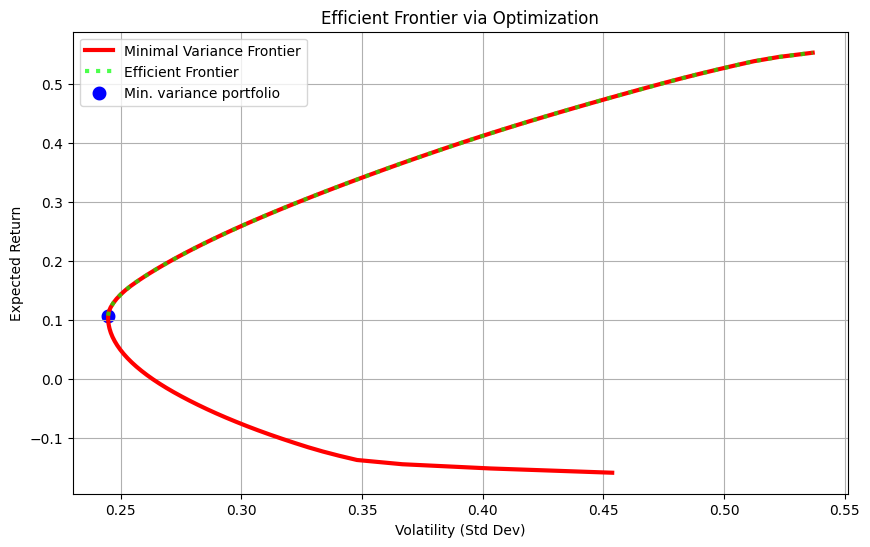

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(frontier_risks, target_returns, 'red', lw=3, label="Minimal Variance Frontier")
plt.plot(x, y, color='lime', lw=3, linestyle=':', alpha=0.7, label='Efficient Frontier')
plt.scatter(min(frontier_risks), target_returns[frontier_risks.index(min(frontier_risks))], lw=4, color='blue', label='Min. variance portfolio')
plt.xlabel("Volatility (Std Dev)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier via Optimization")
plt.grid(True)
plt.legend()
plt.show()

# 🔝 Optimal portfolio using Sharpe ratio

In [27]:
def sharpe_ratio(weights):
    return (portfolio_return(weights) - 0.02) / (portfolio_volatility(weights))

In [28]:
def negative_sharpe_ratio(weights):
    return -sharpe_ratio(weights)

In [29]:
constraints = {'type': 'eq', 'fun': lambda weight: np.sum(weight)-1}
bounds = tuple((0, 0.15) for _ in range(len(initial_weights)))

In [30]:
optimal = minimize(fun=negative_sharpe_ratio, x0=initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)

In [31]:
optimal_weights = optimal.x

In [32]:
print(f'Expected return: {portfolio_return(optimal_weights)*100:.3f}%')
print(f'Volatility of portfolio: {portfolio_volatility(optimal_weights)*100:.3f}%')
print(f'Sharpe ratio of optimal portfolio: {sharpe_ratio(optimal_weights):.2f}')
print(f'Sharpe ratio of basic portfolio: {sharpe_ratio(initial_weights):.2f}')

Expected return: 31.035%
Volatility of portfolio: 33.751%
Sharpe ratio of optimal portfolio: 0.86
Sharpe ratio of basic portfolio: 0.55


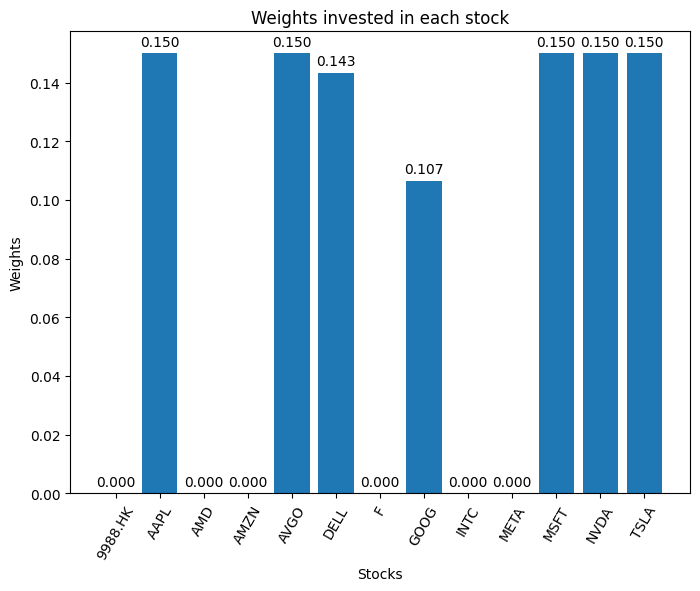

In [33]:
plt.figure(figsize=(8,6))
plt.title('Weights invested in each stock')
bars = plt.bar(df_returns.columns, optimal_weights)
plt.xlabel('Stocks')
plt.xticks(rotation=60)
plt.ylabel('Weights')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.0015,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.show()

#### 🐬 Second portfolio optimization changing weights allocation bounds constraints

In [34]:
bounds = tuple((-0.3, 0.3) for _ in range(len(initial_weights)))

In [35]:
optimal = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', constraints=constraints, bounds=bounds)

In [36]:
optimal_weights = optimal.x

In [37]:
print(f'Expected return: {portfolio_return(optimal_weights)*100:.3f}%')
print(f'Volatility of portfolio: {portfolio_volatility(optimal_weights)*100:.3f}%')
print(f'Sharpe ratio of optimal portfolio: {sharpe_ratio(optimal_weights):.2f}')

Expected return: 54.700%
Volatility of portfolio: 40.684%
Sharpe ratio of optimal portfolio: 1.30


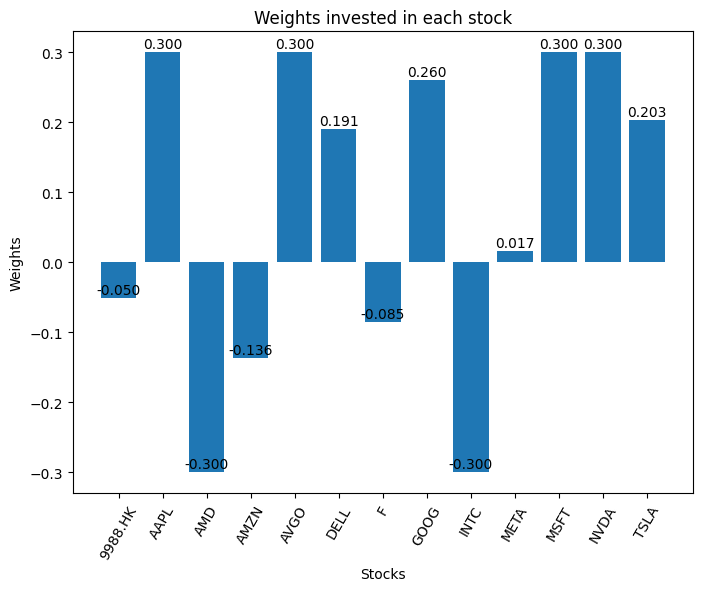

In [38]:
plt.figure(figsize=(8,6))
plt.title('Weights invested in each stock')
bars = plt.bar(df_returns.columns, optimal_weights)
plt.xlabel('Stocks')
plt.xticks(rotation=60)
plt.ylabel('Weights')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.0015,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.show()